<a href="https://colab.research.google.com/github/anujavenkatachalam04/chvi_vbd_rj/blob/main/notebooks/impute_remote_sensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explore missing data for remote sensing data, impute

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
from shapely.geometry import Point
from scipy.spatial.distance import pdist, squareform
import esda
from pykrige.ok import OrdinaryKriging

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -r https://raw.githubusercontent.com/anujavenkatachalam04/chvi_vbd_rj/main/requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.4/681.4 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1

In [ ]:
os.chdir("/content/drive/MyDrive/CHVI")

In [ ]:
path="1_Data/Remote_Sensing/Raw"

In [ ]:
output_path="1_Data/Remote_Sensing/Processed"

In [ ]:
os.listdir(path)

['ndvi_10kmx10km_grid.gpkg',
 'ndwi_10kmx10km_grid.gpkg',
 'ndbi_10kmx10km_grid.gpkg',
 'individual_files',
 'lulc_10kmx10km_grid.gpkg']

In [ ]:
# import remote sensing files

ndvi=gpd.read_file(f"{path}/ndvi_10kmx10km_grid.gpkg")
ndbi=gpd.read_file(f"{path}/ndbi_10kmx10km_grid.gpkg")
ndwi=gpd.read_file(f"{path}/ndwi_10kmx10km_grid.gpkg")
lulc=gpd.read_file(f"{path}/lulc_10kmx10km_grid.gpkg")

In [ ]:
lulc.columns

Index(['C_CODE11', 'DISTRICT', 'Date', 'NAME', 'bare', 'built', 'crops',
       'flooded_vegetation', 'grass', 'grid_id', 'shrub_and_scrub',
       'snow_and_ice', 'trees', 'water', 'urbanization_index',
       'surface_water_fraction', 'agriculture_fraction', 'vegetation_cover',
       'nonhabitat_fraction', 'geometry'],
      dtype='object')

In [ ]:
lulc_filt=lulc[['C_CODE11', 'DISTRICT', 'Date', 'NAME','urbanization_index',
       'geometry', 'grid_id' ]].rename(columns={"urbanization_index":"lulc_data"})

In [ ]:
missing_ndvi=ndvi[ndvi["NDVI"].isna()]["grid_id"].unique()

In [ ]:
missing_ndbi=ndbi[ndbi["NDBI"].isna()]["grid_id"].unique()

In [ ]:
missing_ndwi=ndwi[ndwi["NDWI"].isna()]["grid_id"].unique()

In [ ]:
missing_lulc=lulc_filt[lulc_filt["lulc_data"].isna()]["grid_id"].unique()

In [ ]:
if set(missing_ndvi) == set(missing_ndbi) == set(missing_ndwi):
    print("All three lists contain the same elements.")
else:
    print("There are differences in the elements.")


All three lists contain the same elements.


In [ ]:
if set(missing_ndvi) == set(missing_lulc):
    print("All lists contain the same elements.")
else:
    print("There are differences in the elements.")


There are differences in the elements.


In [ ]:
len(missing_ndvi), len(missing_lulc)

(2983, 3016)

In [ ]:
print("Overlap b/w ndvi, lulc, missing_lulc")
len(set(missing_lulc).intersection(set(missing_ndvi)))/len(set(missing_ndvi).union(set(missing_lulc)))

Overlap b/w ndvi, lulc, missing_lulc


0.8996200126662445

# Missing EDA

# 1. Overall Missing Fraction
- 13-14% which needs imputation, but can be handled

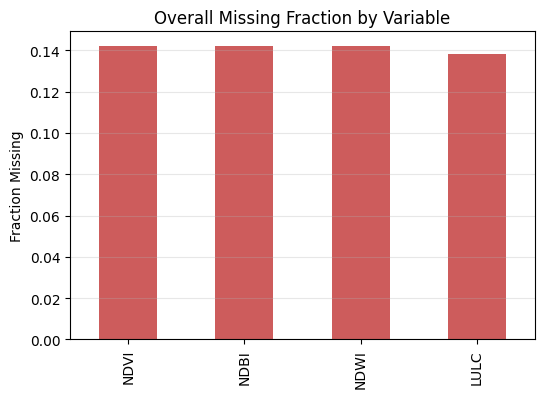

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine basic missingness info
summary = pd.DataFrame({
    'NDVI': ndvi['NDVI'].isna().mean(),
    'NDBI': ndbi['NDBI'].isna().mean(),
    'NDWI': ndwi['NDWI'].isna().mean(),
    'LULC': lulc_filt[['lulc_data']].isna().mean().mean()
}, index=['Missing Fraction']).T

summary.plot(kind='bar', legend=False, figsize=(6,4), color='indianred')
plt.title("Overall Missing Fraction by Variable")
plt.ylabel("Fraction Missing")
plt.grid(axis='y', alpha=0.3)
plt.show()


# Temporal missingness
- Missingness peaks during certain months → July & August (and a little bit in September) -  monsoon/cloud-driven → use spatial interpolation (kriging).
- Long continuous gaps → temporal interpolation unreliable → use spatial neighbors or spatio-temporal kriging.

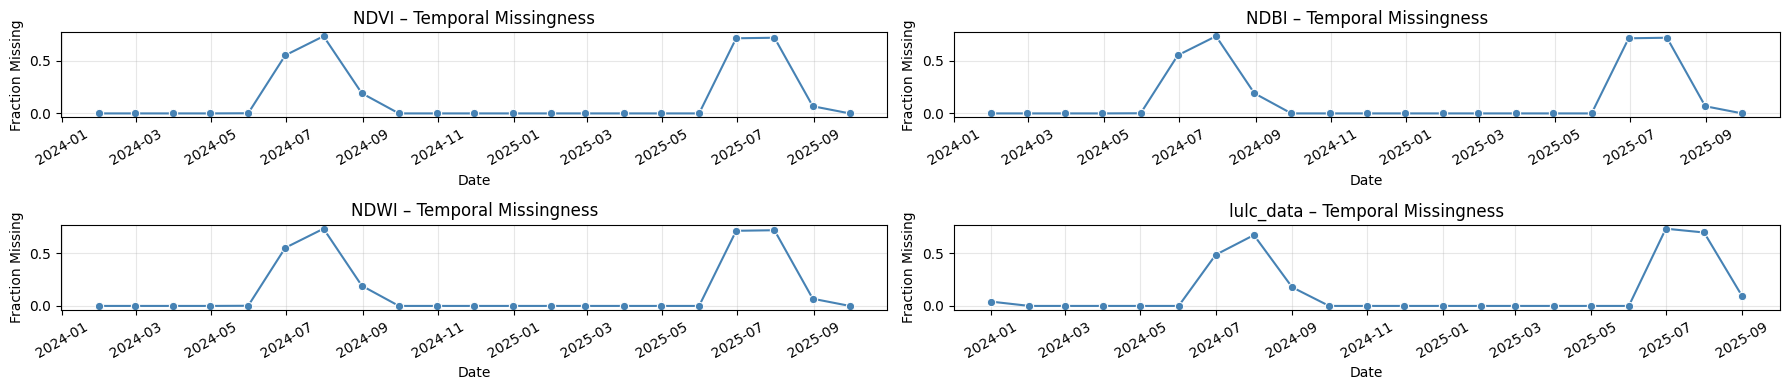

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_temporal_missing(df, var, ax):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    temp = df.groupby('Date')[var].apply(lambda x: x.isna().mean()).reset_index()
    sns.lineplot(data=temp, x='Date', y=var, ax=ax, marker='o', color='steelblue')
    ax.tick_params(axis='x', rotation=30)
    ax.set_title(f"{var} – Temporal Missingness")
    ax.set_ylabel("Fraction Missing")
    ax.set_xlabel("Date", rotation=0)
    ax.grid(alpha=0.3)

# Create subplots for NDVI, NDBI, NDWI, and LULC
fig, axes = plt.subplots(2, 2, figsize=(18, 4))

plot_temporal_missing(ndvi, 'NDVI', axes[0][0])
plot_temporal_missing(ndbi, 'NDBI', axes[0][1])
plot_temporal_missing(ndwi, 'NDWI', axes[1][0])
plot_temporal_missing(lulc_filt, 'lulc_data', axes[1][1])
plt.tight_layout()
plt.show()



In [ ]:
ndvi.columns, ndbi.columns, ndwi.columns, lulc_filt.columns

# Spatial Missingness

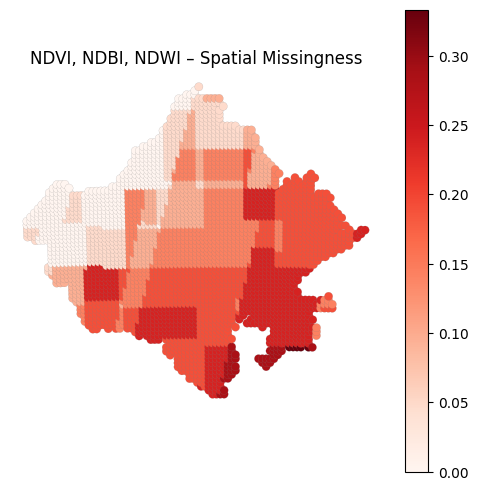

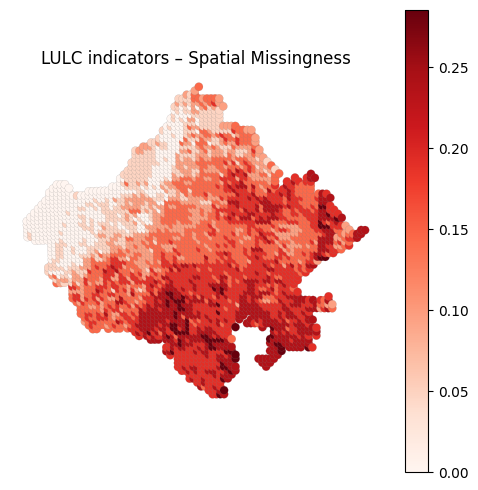

In [ ]:
import geopandas as gpd

def plot_spatial_missing(gdf, var, title):
    temp = gdf.groupby('grid_id')[var].apply(lambda x: x.isna().mean()).reset_index()
    merged = gdf[['grid_id', 'geometry']].drop_duplicates().merge(temp, on='grid_id', how='left')
    fig, ax = plt.subplots(figsize=(6,6))
    merged.plot(column=var, cmap='Reds', legend=True, ax=ax, edgecolor='gray', linewidth=0.1)
    ax.set_title(title)
    ax.axis('off')

plot_spatial_missing(ndvi, 'NDVI', 'NDVI, NDBI, NDWI – Spatial Missingness')

plot_spatial_missing(lulc_filt, 'lulc_data', 'LULC indicators – Spatial Missingness')


In [ ]:
lulc_filt["grid_id"].nunique()

3420

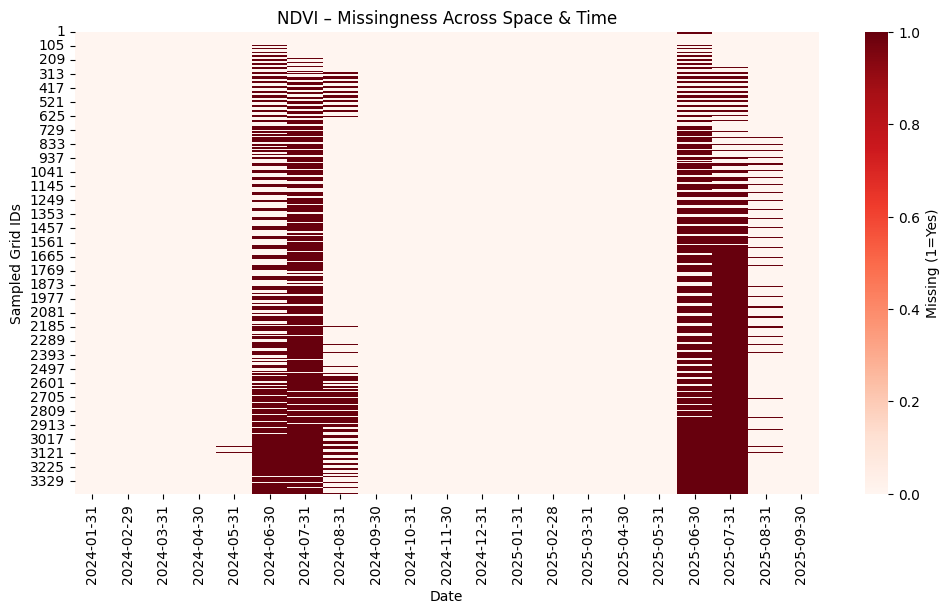

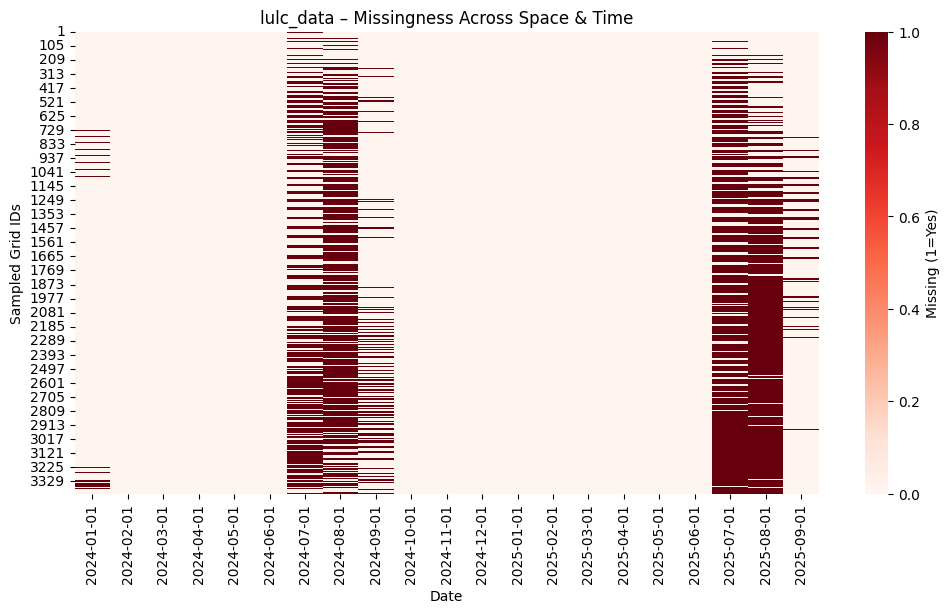

In [ ]:
def plot_missing_heatmap(df, var, sample_grids=3420):
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    pivot = (df.pivot_table(index='grid_id', columns='Date', values=var, aggfunc='mean')
               .isna().astype(int))
    if pivot.shape[0] > sample_grids:
        pivot = pivot.sample(sample_grids, random_state=0)
    plt.figure(figsize=(12,6))
    sns.heatmap(pivot, cmap='Reds', cbar_kws={'label': 'Missing (1=Yes)'})
    plt.title(f"{var} – Missingness Across Space & Time")
    plt.xlabel("Date")
    plt.ylabel("Sampled Grid IDs")
    plt.show()

plot_missing_heatmap(ndvi, 'NDVI')
plot_missing_heatmap(lulc_filt, 'lulc_data')


In [ ]:
# Vertical red bands → missingness in certain time periods → temporal issue (clouds).

# Horizontal red bands → missingness in certain grids → spatial issue (persistent coverage loss).

# Checkerboard pattern → random → simpler interpolation OK.

In [ ]:
from esda.moran import Moran
from libpysal.weights import Queen

def morans_I_for_missing(gdf, var):
    gdf['missing'] = gdf[var].isna().astype(int)
    w = Queen.from_dataframe(gdf)
    moran = Moran(gdf['missing'], w)
    print(f"{var}: Moran’s I = {moran.I:.3f}, p = {moran.p_sim:.4f}")

morans_I_for_missing(ndvi, 'NDVI')
morans_I_for_missing(lulc_filt, 'lulc_data')


/tmp/ipython-input-2120481557.py:6: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)


NDVI: Moran’s I = 0.044, p = 0.0010


/tmp/ipython-input-2120481557.py:6: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)


lulc_data: Moran’s I = 0.038, p = 0.0010


# Notes on Missingness

| Aspect                         | Observation                                          | Implication                                         |
| ------------------------------ | ---------------------------------------------------- | --------------------------------------------------- |
| **Spatial autocorrelation**    | Moran’s I significant for both NDVI & LULC           | Spatial structure → interpolate spatially           |
| **Temporal pattern**           | Earlier plots showed clustered missing periods       | Temporal structure → include time trend             |
| **Cross-variable correlation** | 90 % overlap of missing NDVI, NDBI, NDWI, LULC       | Common cause (e.g., cloud/shadow masking)           |
| **Overall**                    | Missingness is both spatially & temporally dependent | Use **spatio-temporal imputation**, not random fill |


# Solution

1) For NDVI, NDBI, NDWI:

Two-step hybrid:
A. Temporal interpolation within grid
B. Then spatial interpolation for remaining NaNs (kriging or IDW using centroids).

2) For LULC:
- Only spatial interpolation, not temporal interpolation as LULC changes on a slow time scale

In [ ]:
def temporal_interpolation(df, var):
    df = df.sort_values(['grid_id', 'Date']).copy()
    df[var] = df.groupby('grid_id')[var].transform(
        lambda x: x.interpolate(method='time', limit_direction='both')
    )
    return df

In [ ]:
def safe_krige_per_month(df_month, col, xcol="x_m", ycol="y_m"):
    """Kriging with safety bounds to prevent extreme values"""
    non_null = df_month[~df_month[col].isna()]
    nulls = df_month[df_month[col].isna()]

    if nulls.empty or non_null.empty:
        return pd.Series(dtype=float)

    q01 = non_null[col].quantile(0.01)
    q99 = non_null[col].quantile(0.99)
    mean_val = non_null[col].mean()
    std_val = non_null[col].std()

    bounds = {
    'NDVI': (-1, 1),
    'NDBI': (-1, 1),
    'NDWI': (-1, 1),
    'urbanization_index': (0, 1),
    'surface_water_fraction': (0, 1),
    'agriculture_fraction': (0, 1),
    'vegetation_cover': (0, 1),
    'nonhabitat_fraction': (0, 1)}

    if col in bounds:
        lower_bound, upper_bound = bounds[col]
    else:
        lower_bound = max(q01 - 3*std_val, non_null[col].min())
        upper_bound = min(q99 + 3*std_val, non_null[col].max())

    if len(non_null) < 6:
        return pd.Series([mean_val] * len(nulls), index=nulls.index)

    try:
        OK = OrdinaryKriging(
            non_null[xcol].values,
            non_null[ycol].values,
            non_null[col].values,
            variogram_model="spherical",
            verbose=False,
            enable_plotting=False,
        )
        z, _ = OK.execute("points", nulls[xcol].values, nulls[ycol].values)
        z = np.clip(z, lower_bound, upper_bound)
        return pd.Series(z, index=nulls.index)
    except Exception:
        return pd.Series([mean_val] * len(nulls), index=nulls.index)


In [ ]:
def spatial_impute_by_month(df, var):
    df = df.copy()
    df[['x_m', 'y_m']] = df.geometry.centroid.apply(lambda g: pd.Series([g.x, g.y]))

    for date, df_month in df.groupby('Date'):
        missing_idx = df_month[df_month[var].isna()].index
        if len(missing_idx) > 0:
            z = safe_krige_per_month(df_month, var)
            df.loc[missing_idx, var] = z
    return df

In [ ]:
ndvi_copy=ndvi.copy()
ndbi_copy=ndbi.copy()
ndwi_copy=ndwi.copy()

In [ ]:
ndvi.isna().sum()

,0
NAME,0
DISTRICT,0
C_CODE11,0
grid_id,0
NDVI,10207
source,10207
Date,0
geometry,0


In [ ]:
# Apply temporal + spatial interpolation and set time index
for var, dataset in [('NDVI', ndvi_copy), ('NDBI', ndbi_copy), ('NDWI', ndwi_copy)]:
    print(f"Imputing {var} ...")

    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset = dataset.sort_values('Date').set_index('Date')

    if dataset.crs.is_geographic:
      dataset = dataset.to_crs(epsg=32643)

    # Step 1: Temporal interpolation
    df_temp = temporal_interpolation(dataset, var)

    # Step 2: Spatial imputation
    df_full = spatial_impute_by_month(df_temp, var)

    # Optional: Check missing fraction after imputation
    missing_after = df_full[var].isna().mean()
    print(f"✅ {var} imputation complete. Remaining missing fraction: {missing_after:.2%}\n")

    # Step 4: Save to CSV (with Date as index)
    df_full.to_file(f"{output_path}/{var}_hybrid_imputed.gpkg", driver="GPKG")

    # Optional: print columns to verify structure
    print("Columns:", df_full.columns.tolist(), "\n")


Imputing NDVI ...
✅ NDVI imputation complete. Remaining missing fraction: 0.00%

Columns: ['NAME', 'DISTRICT', 'C_CODE11', 'grid_id', 'NDVI', 'source', 'geometry', 'x_m', 'y_m'] 

Imputing NDBI ...
✅ NDBI imputation complete. Remaining missing fraction: 0.00%

Columns: ['NAME', 'DISTRICT', 'C_CODE11', 'grid_id', 'NDBI', 'source', 'geometry', 'x_m', 'y_m'] 

Imputing NDWI ...
✅ NDWI imputation complete. Remaining missing fraction: 0.00%

Columns: ['NAME', 'DISTRICT', 'C_CODE11', 'grid_id', 'NDWI', 'source', 'geometry', 'x_m', 'y_m'] 



In [ ]:
# Apply spatial interpolation for lulc
lulc[['bare', 'built', 'crops',
       'flooded_vegetation', 'grass', 'grid_id', 'shrub_and_scrub',
       'snow_and_ice', 'trees', 'water', 'urbanization_index',
       'surface_water_fraction', 'agriculture_fraction', 'vegetation_cover',
       'nonhabitat_fraction', 'geometry']]

,bare,built,crops,flooded_vegetation,grass,grid_id,shrub_and_scrub,snow_and_ice,trees,water,urbanization_index,surface_water_fraction,agriculture_fraction,vegetation_cover,nonhabitat_fraction,geometry
0,0.234728,0.037607,0.157674,0.034201,0.034678,1,0.356286,0.041866,0.066142,0.033601,0.076018,0.067801,0.157674,0.457106,0.276594,POINT (69.58509 26.75094)
1,0.582735,0.062310,0.081525,0.029229,0.023475,2,0.128997,0.028643,0.016615,0.046138,0.269278,0.075366,0.081525,0.169088,0.611378,POINT (69.5808 26.84083)
2,0.414445,0.037383,0.111677,0.030180,0.043585,3,0.246450,0.038226,0.033472,0.043878,0.103585,0.074058,0.111677,0.323508,0.452671,POINT (69.5765 26.93071)
3,0.365080,0.036480,0.099949,0.035277,0.052367,4,0.272570,0.042118,0.051396,0.043453,0.088368,0.078730,0.099949,0.376334,0.407197,POINT (69.57218 27.02059)
4,0.429645,0.035652,0.084715,0.033052,0.041839,5,0.258701,0.038777,0.035644,0.041480,0.095882,0.074532,0.084715,0.336184,0.468422,POINT (69.56784 27.11047)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71815,NaN,NaN,NaN,NaN,NaN,3416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (78.02682 26.73203)
71816,NaN,NaN,NaN,NaN,NaN,3417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (78.02922 26.82219)
71817,NaN,NaN,NaN,NaN,NaN,3418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (78.1297 26.82)
71818,NaN,NaN,NaN,NaN,NaN,3419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (78.13219 26.91015)


In [ ]:
lulc_copy = lulc.copy()


if lulc_copy.crs.is_geographic:
  lulc_copy = lulc_copy.to_crs(epsg=32643)

# List of LULC fraction columns to impute
lulc_vars = [
    'bare', 'built', 'crops', 'flooded_vegetation', 'grass',
    'shrub_and_scrub', 'snow_and_ice', 'trees', 'water'
]

# Apply spatial interpolation for each LULC variable
for var in lulc_vars:
    print(f"Imputing {var} ...")

    df_imputed = spatial_impute_by_month(lulc_copy, var)

    missing_after = df_imputed[var].isna().mean()
    print(f"✅ {var} imputation complete. Remaining missing fraction: {missing_after:.2%}\n")

# After all LULC vars are imputed, recompute indices
lulc_copy['urbanization_index'] = lulc_copy['built'] + lulc_copy['bare']
lulc_copy['vegetation_cover'] = lulc_copy['trees'] + lulc_copy['grass'] + lulc_copy['crops']
lulc_copy['nonhabitat_fraction'] = lulc_copy['built'] + lulc_copy['bare'] + lulc_copy['snow_and_ice']
lulc_copy['surface_water_fraction'] = lulc_copy['water'] + lulc_copy['flooded_vegetation']
lulc_copy['agriculture_fraction'] = lulc_copy['crops'] + lulc_copy['flooded_vegetation']


Imputing bare ...
✅ bare imputation complete. Remaining missing fraction: 0.00%

Imputing built ...
✅ built imputation complete. Remaining missing fraction: 0.00%

Imputing crops ...
✅ crops imputation complete. Remaining missing fraction: 0.00%

Imputing flooded_vegetation ...
✅ flooded_vegetation imputation complete. Remaining missing fraction: 0.00%

Imputing grass ...
✅ grass imputation complete. Remaining missing fraction: 0.00%

Imputing shrub_and_scrub ...
✅ shrub_and_scrub imputation complete. Remaining missing fraction: 0.00%

Imputing snow_and_ice ...
✅ snow_and_ice imputation complete. Remaining missing fraction: 0.00%

Imputing trees ...
✅ trees imputation complete. Remaining missing fraction: 0.00%

Imputing water ...
✅ water imputation complete. Remaining missing fraction: 0.00%



In [ ]:
lulc_copy.to_file(f"{output_path}/lulc_spatial_imputed.gpkg", driver="GPKG")


In [ ]:
# The End!